# Single Particle Model (SPM) 

## Model Equations

The SPM consists of two spherically symmetric diffusion equations: one within a representative negative particle ($k=\text{n}$) and one within a representative positive particle ($k=\text{p}$). In the centre of the particle the classical no-flux condition is imposed. Since the SPM assumes that all particles in an electrode behave in exactly the same way, the flux on the surface of a particle is simply the current divided by the thickness of the electrode. We shall use $r_k\in[0,1]$ for the radial coordinate of the particle in electrode $k$. The concentration of lithium in electrode $k$ is denoted $c_k$ and the current is denoted by $\mathcal{I}$. All parameters in the model stated here are dimensionless and are given in terms of dimensional parameters at the end of this notebook.The model equations for the SPM are then: 
$$
\frac{\partial c_k}{\partial t} = \gamma_k \frac{\partial}{\partial r_k}\left( r_k^2 \frac{\partial c_k}{\partial r_k} \right) \\ 
\frac{\partial c_k}{\partial r_k}\bigg|_{r_k=0} = 0, \quad -\beta_k \hat{C}_k \gamma_k \frac{\partial c_k}{\partial r_k}\bigg|_{r_k=1} = \begin{cases} 
    \frac{\mathcal{I}}{L_n}, \quad k=\text{n}, \\ 
    -\frac{\mathcal{I}}{L_p}, \quad k=\text{p},
\end{cases} ,
$$ 
for $k\in\{\text{n, p}\}$.

### Voltage Expression
The terminal voltage is obtained from the expression: 
$$
V = U_p(c_p)\big|_{r_p=1}-U_n(c_n)\big|_{r_n=1}-\frac{2}{\Lambda}\sinh^{-1}\left(\frac{\mathcal{I}}{g_p L_p} \right)  -\frac{2}{\Lambda}\sinh^{-1}\left(\frac{\mathcal{I}}{g_n L_n} \right)
$$
with the exchange current densities given by
$$
g_k = m_k \hat{C}_k (c_k)^{1/2} (1-c_k)^{1/2}, \quad \text{for } k\in\{\text{n, p}\}.
$$

## Example solving SPM using PyBaMM

Below we show how to solve the SPM model, using the default geometry, mesh, paramters, discretisation and solver provided with PyBaMM.

First we need to import pybamm, and then change our working directory to the root of the pybamm folder. 

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

We then get the SPM model equations:

In [2]:
model = pybamm.lithium_ion.SPM()

The model object is a subtype of [`pybamm.BaseModel`](https://pybamm.readthedocs.io/en/latest/source/models/base_model.html), and contains all the equations that define this particular model. For example, the `rhs` dict contained in `model` has a dictionary mapping variables such as $c_n$ to the equation representing its rate of change with time (i.e. $\partial{c_n}/\partial{t}$). We can see this explicitly be visualising this entry in the `rhs` dict:

In [3]:
variable = next(iter(model.rhs.keys()))
equation = next(iter(model.rhs.values()))
print('rhs equation for variable \'',variable,'\' is:')
path = 'examples/notebooks/models/'
equation.visualise(path+'spm1.png')

rhs equation for variable ' Negative particle concentration ' is:


![](spm1.png)

We need a geometry to define our model equations over. In pybamm this is represented by the [`pybamm.Geometry`](https://pybamm.readthedocs.io/en/latest/source/geometry/geometry.html) class. In this case we use the default geometry object defined by the model

In [4]:
geometry = model.default_geometry

This geometry object defines a number of geometry domains, each with its own name, spatial variables and min/max limits (the latter are represented as equations similar to the rhs equation shown above). For instance, the SPM model has the following domains:

In [5]:
print('SPM domains:')
for i, (k, v) in enumerate(geometry.items()):
    print(str(i+1)+'.',k,'with variables:')
    for var, rng in v['primary'].items():
        print('  -(',rng['min'],') <=',var,'<= (',rng['max'],')')

SPM domains:
1. negative electrode with variables:
  -( 0.0 ) <= x_n <= ( Negative electrode width / Negative electrode width + Separator width + Positive electrode width )
2. separator with variables:
  -( Negative electrode width / Negative electrode width + Separator width + Positive electrode width ) <= x_s <= ( Negative electrode width / Negative electrode width + Separator width + Positive electrode width + Separator width / Negative electrode width + Separator width + Positive electrode width )
3. positive electrode with variables:
  -( Negative electrode width / Negative electrode width + Separator width + Positive electrode width + Separator width / Negative electrode width + Separator width + Positive electrode width ) <= x_p <= ( 1.0 )
4. negative particle with variables:
  -( 0.0 ) <= r_n <= ( 1.0 )
5. positive particle with variables:
  -( 0.0 ) <= r_p <= ( 1.0 )


Both the model equations and the geometry are defined by a set of parameters, such as $\gamma_p$ or $L_p$. We can substitute these symbolic parameters in the model with values by using the [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/parameters/parameter_values.html) class, which takes either a python dictionary or CSV file with the mapping between parameter names and values. Rather than create our own instance of `pybamm.ParameterValues`, we will use the default parameter set included in the model

In [6]:
param = model.default_parameter_values

We can then apply this parameter set to the model and geometry

In [7]:
param.process_model(model)
param.process_geometry(geometry)

The next step is to mesh the input geometry. We can do this using the [`pybamm.Mesh`](https://pybamm.readthedocs.io/en/latest/source/meshes/meshes.html) class. This class takes in the geometry of the problem, and also two dictionaries containing the type of mesh to use within each domain of the geometry (i.e. within the positive or negative electrode domains), and the number of mesh points. 

The default mesh types and the default number of points to use in each variable for the SPH model are:

In [8]:
for k, t in model.default_submesh_types.items():
    print(k,'is of type',t.__name__)
for var, npts in model.default_var_pts.items():
    print(var,'has',npts,'mesh points')

negative electrode is of type Uniform1DSubMesh
separator is of type Uniform1DSubMesh
positive electrode is of type Uniform1DSubMesh
negative particle is of type Uniform1DSubMesh
positive particle is of type Uniform1DSubMesh
x_n has 40 mesh points
x_s has 25 mesh points
x_p has 35 mesh points
r_n has 10 mesh points
r_p has 10 mesh points


With these defaults, we can then create our mesh of the given geometry:

In [9]:
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

The next step is to discretise the model equations over this mesh. We do this using the [`pybamm.Discretisation`](https://pybamm.readthedocs.io/en/latest/source/discretisations/discretisation.html) class, which takes both the mesh we have already created, and a dictionary of spatial methods to use for each geometry domain. For the case of the SPM model, we use the following defaults for the spatial discretisation methods:

In [10]:
for k, method in model.default_spatial_methods.items():
    print(k,'is discretised using',method.__name__,'method')

macroscale is discretised using FiniteVolume method
negative particle is discretised using FiniteVolume method
positive particle is discretised using FiniteVolume method


We then create the `pybamm.Discretisation` object, and use this to discretise the model equations

In [11]:
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

After this stage, all the equations in `model` have been discretised into purely linear algebra expressions that are ready to be evaluated within a time-stepping loop of a given solver. For example, the rhs expression for $\partial{c_n}/\partial{t}$ that we visualised above is now represented by:

In [12]:
model.concatenated_rhs.children[0].visualise(path+'spm2.png')

![](spm2.png)

Now we are ready to run the time-stepping loop to solve the model. Once again we use the default ODE solver like so:

In [13]:
# Solve the model at the given time points
solver = model.default_solver
n = 100
t_eval = np.linspace(0, 1, n)
print('Solving using',type(solver).__name__,'solver...')
solver.solve(model, t_eval)
print('Finished.')

Solving using ScikitsOdeSolver solver...
Finished.


Each model in pybamm has a list of relevent variables defined in the model, for use in visualising the model solution or for comparison with other models. The SPM model defines the following variables:

In [14]:
print('SPM model variables:')
for v in model.variables.keys():
    print('\t-',v)

SPM model variables:
	- Total current density
	- Total current density [A m-2]
	- Negative electrode current density
	- Positive electrode current density
	- Electrolyte current density
	- Interfacial current density
	- Exchange-current density
	- Negative electrode current density [A m-2]
	- Positive electrode current density [A m-2]
	- Electrolyte current density [A m-2]
	- Interfacial current density [A m-2]
	- Exchange-current density [A m-2]
	- Negative electrode open circuit potential
	- Positive electrode open circuit potential
	- Average negative electrode open circuit potential
	- Average positive electrode open circuit potential
	- Average open circuit voltage
	- Measured open circuit voltage
	- Terminal voltage
	- Negative electrode open circuit potential [V]
	- Positive electrode open circuit potential [V]
	- Average negative electrode open circuit potential [V]
	- Average positive electrode open circuit potential [V]
	- Average open circuit voltage [V]
	- Measured open cir

To help visualise the results, pybamm provides the `pybamm.ProcessedVariable` class, which takes the output of a solver and a variable, and allows the user to evaluate the value of that variable at any given time or $x$ value. For example, we can create a `pybamm.ProcessedVariable` using the SPM voltage variable, and plot the voltage versus time, along with the surface particle concentration.

In [17]:
voltage = pybamm.ProcessedVariable(model.variables['Terminal voltage [V]'], solver.t, solver.y, mesh=mesh)
spc_n = pybamm.ProcessedVariable(
    model.variables['Negative particle surface concentration'], solver.t, solver.y, mesh=mesh
)
spc_p = pybamm.ProcessedVariable(
    model.variables['Positive particle surface concentration'], solver.t, solver.y, mesh=mesh
)

One we have these variables in hand, we can begin generating plots using a library such as Matplotlib. Below we plot the terminal voltage and surface particle concentrations versus time

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

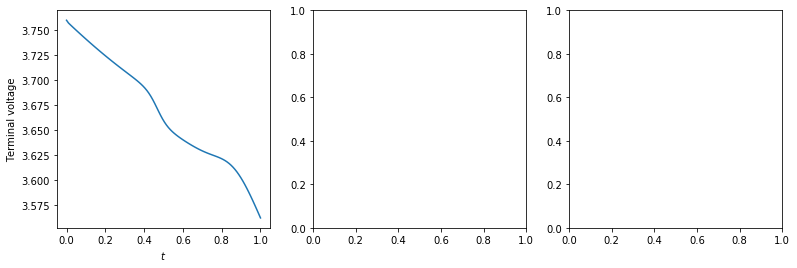

In [18]:
%matplotlib inline
t = np.linspace(0,1,100)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))

ax1.plot(t, voltage(t=t).reshape(-1))
ax1.set_xlabel(r'$t$')
ax1.set_ylabel('Terminal voltage')

ax2.plot(t, spc_n(t=t).reshape(-1))
ax2.set_xlabel(r'$t$')
ax2.set_ylabel('Negative particle surface concentration')

ax3.plot(t, spc_p(t=t).reshape(-1))
ax3.set_xlabel(r'$t$')
ax3.set_ylabel('Positive particle surface concentration')

plt.tight_layout()
plt.show()

Some of the output variables are defined over space as well as time. Once option to visualise these variables is to use the `interact` slider widget. Below we plot the negative/positive particle concentration over $r$, using a slider to change the current time point

In [19]:
c_n = pybamm.ProcessedVariable(model.variables['Negative particle concentration'], solver.t, solver.y, mesh=mesh)
c_p = pybamm.ProcessedVariable(model.variables['Positive particle concentration'], solver.t, solver.y, mesh=mesh)
r = np.linspace(0,1,100)

def plot_concentrations(t):
    f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,5))
    plot_c_n, = ax1.plot(r, c_n(x=r,t=t))
    plot_c_p, = ax2.plot(r, c_p(x=r,t=t))
    ax1.set_ylabel('Negative particle concentration')
    ax2.set_ylabel('Positive particle concentration')
    ax1.set_xlabel(r'$r_n$')
    ax2.set_xlabel(r'$r_p$')
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    plt.show()
    
import ipywidgets as widgets
widgets.interact(plot_concentrations, t=widgets.FloatSlider(min=0,max=1,step=0.1,value=0));


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…